In [234]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
from datetime import datetime, timedelta

sns.set_style("darkgrid")
%matplotlib inline 

In [235]:
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix

# Import the data

In [236]:
with open('ultimate_data_challenge.json', 'r') as f: 
    j = json.load(f)

In [237]:
data = pd.DataFrame(j)

# Basic Dataset info

In [238]:
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])
data['signup_date'] = pd.to_datetime(data['signup_date'])

In [239]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [240]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [241]:
data.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


# Create an "active" variable

In [242]:
max_date = data['last_trip_date'].max()
d = max_date - timedelta(days=30)

In [243]:
data['active'] = data.apply(lambda x:1 if x['last_trip_date'] >= d else 0 , axis = 1)

# Look at the break down of active vs. inactive

In [244]:
data['active'].value_counts(normalize = True)

0    0.62392
1    0.37608
Name: active, dtype: float64

In [245]:
data[data.active == 0]['city'].value_counts(normalize = True)

Winterfell        0.484774
Astapor           0.394474
King's Landing    0.120753
Name: city, dtype: float64

In [246]:
data[data.active == 1]['city'].value_counts(normalize = True)

Winterfell        0.436769
King's Landing    0.338385
Astapor           0.224846
Name: city, dtype: float64

In [247]:
active = data[data.active == 1]

# Plots

In [248]:
active.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0,1
13,3.04,5.0,4.0,1.38,King's Landing,2014-06-08,iPhone,2014-01-29,50.0,0,False,50.0,1
16,10.86,3.0,5.0,1.00,King's Landing,2014-06-28,Android,2014-01-11,0.0,1,True,50.0,1


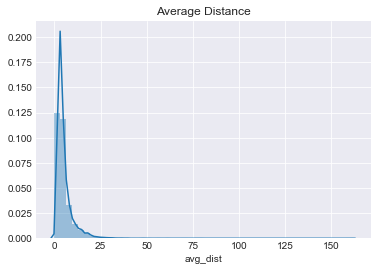

In [249]:
sns.distplot(active['avg_dist'])
plt.title('Average Distance');

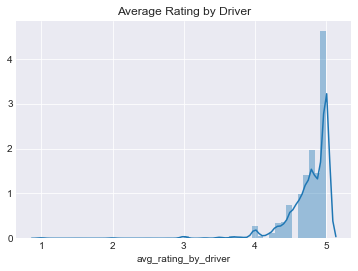

In [250]:
sns.distplot(active[pd.isnull(active["avg_rating_by_driver"]) == False]['avg_rating_by_driver'])
plt.title('Average Rating by Driver');

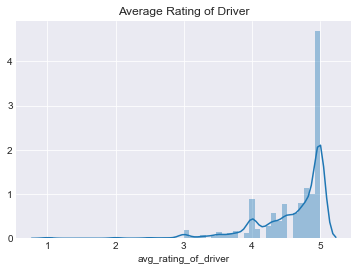

In [251]:
sns.distplot(active[pd.isnull(active["avg_rating_of_driver"]) == False]['avg_rating_of_driver'])
plt.title('Average Rating of Driver');

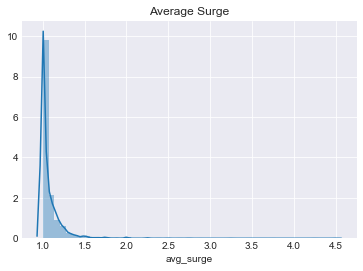

In [252]:
sns.distplot(active["avg_surge"])
plt.title('Average Surge');

In [253]:
active['phone'].value_counts(normalize=True)

iPhone     0.831503
Android    0.168497
Name: phone, dtype: float64

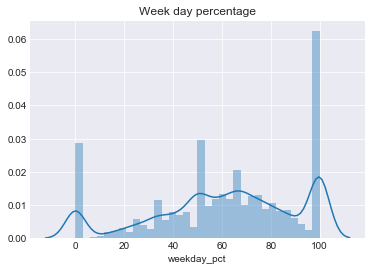

In [254]:
sns.distplot(active["weekday_pct"])
plt.title('Week day percentage');

In [255]:
active['ultimate_black_user'].value_counts(normalize = True)

True     0.505052
False    0.494948
Name: ultimate_black_user, dtype: float64

# Create Dataset

In [256]:
# Variables of interest
_vars = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct',
         'trips_in_first_30_days', 'weekday_pct']

In [257]:
# Subset variables for train/test split
X = data[_vars].values
y = data['active'].values

In [258]:
# Create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Model 1: Logistic Regression

In [259]:
lg = LogisticRegressionCV(random_state = 42, cv = 3)
scaler = StandardScaler()

In [260]:
log_steps = [('impute', imputer), ('scale', scaler), ('model', lg)]
log_pipe = Pipeline(log_steps)

### Fit the model

In [261]:
log_pipe.fit(X_test, y_test);

### Score the training data

In [262]:
log_pipe.score(X_train, y_train)

0.65797014925373132

### Score the test data

In [263]:
log_pipe.score(X_test, y_test)

0.65757575757575759

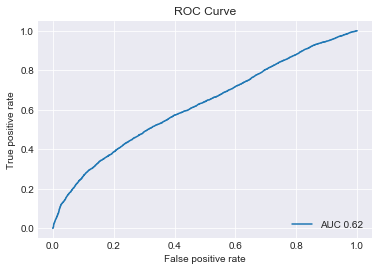

In [264]:
y_pred = log_pipe.predict(X_test)
y_pred_proba = log_pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC" + " {:0.2f}".format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC Curve")
plt.legend(loc=4);

### Classification Report

In [265]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.66      0.95      0.78     10305
          1       0.67      0.17      0.27      6195

avg / total       0.66      0.66      0.59     16500



### Coefficients

In [266]:
pd.DataFrame(list(zip(_vars, log_pipe.named_steps['model'].coef_[0])), columns=['features', 'coef'])

,features,coef
0,avg_dist,-0.165615
1,avg_rating_by_driver,-0.039999
2,avg_rating_of_driver,-0.038709
3,avg_surge,-0.074656
4,surge_pct,0.067232
5,trips_in_first_30_days,0.478724
6,weekday_pct,0.015139


In [267]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [268]:
print("TP:{0}; FP:{1}\nFN:{2}; TN:{3}".format(tp, fp, fn, tn))

TP:1053; FP:508
FN:5142; TN:9797


# Model 2: Random Forest Classifier

In [269]:
# Setup variables
imputer = Imputer()
forest = RandomForestClassifier()
logistic = LogisticRegression()

In [270]:
steps = [('imputer', imputer), 
         ('forest', forest)
        ]

In [271]:
pipe = Pipeline(steps)

In [272]:
grid_parameters = {  
                            'forest__criterion': ['entropy'], 
                            'forest__max_depth':[x for x in range(1,15)], 
                            'forest__n_estimators':[100, 250, 500, 750, 1000, 1250], 
                            'forest__n_jobs':[-1], 
                            'forest__random_state':[42], 
                            'forest__min_samples_split':[20],
                            'imputer__missing_values':['NaN'], 
                            'imputer__strategy':['mean'], 
                            'imputer__axis':[0], 
                           }

In [273]:
grid = GridSearchCV(pipe, grid_parameters, cv=3)
grid.fit(X=X_train, y=y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_im...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'forest__criterion': ['entropy'], 'forest__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'forest__n_estimators': [100, 250, 500, 750, 1000, 1250], 'forest__n_jobs': [-1], 'forest__random_state': [42], 'forest__min_samples_split': [20], 'imputer__missing_values': ['NaN'], 'imputer__strategy': ['mean'], 'imputer__axis': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [274]:
tree_model = grid.best_estimator_
print("Accuracy: {:0.2f}".format(grid.best_score_) )
print("Best Parameters:\t") 
pprint(grid.best_params_) 

Accuracy: 0.75
Best Parameters:	
{'forest__criterion': 'entropy',
 'forest__max_depth': 13,
 'forest__min_samples_split': 20,
 'forest__n_estimators': 500,
 'forest__n_jobs': -1,
 'forest__random_state': 42,
 'imputer__axis': 0,
 'imputer__missing_values': 'NaN',
 'imputer__strategy': 'mean'}


In [275]:
print('Test score: {:0.2f}'.format(grid.score(X_test, y_test)))

Test score: 0.75


### Predict Test

In [276]:
y_pred = grid.predict(X_test)

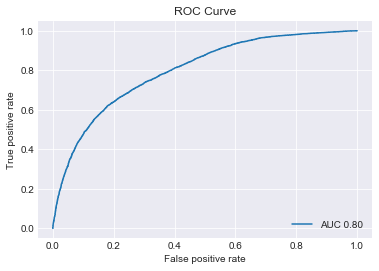

In [277]:
# Set seaborn style 
sns.set_style("darkgrid")

y_pred_proba = grid.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC" + " {:0.2f}".format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC Curve")
plt.legend(loc=4);

### Classification Report

In [278]:
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

          0       0.77      0.85      0.81     10305
          1       0.70      0.57      0.63      6195

avg / total       0.74      0.75      0.74     16500



In [279]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("TP:{0}; FP:{1}\nFN:{2}; TN:{3}".format(tp, fp, fn, tn))

TP:3548; FP:1542
FN:2647; TN:8763


# Feature Importance

In [280]:
feature_importance = grid.best_estimator_.named_steps['forest'].feature_importances_
x = list(zip(_vars, feature_importance))
importance = pd.DataFrame(x, columns=['var', 'importance'])

In [281]:
# Print the importance values 
importance.sort_values('importance', ascending = False)

,var,importance
6,weekday_pct,0.200846
1,avg_rating_by_driver,0.189025
0,avg_dist,0.161728
4,surge_pct,0.157212
5,trips_in_first_30_days,0.117512
3,avg_surge,0.105895
2,avg_rating_of_driver,0.067782
